# Investigating soccer/football match results:

For this Data Analysis project, I've decided to investigate a Soccer DataBase provided by Kaggle.com Kaggle.com is one of the industry leaders in data science and its applications. It hosts multiple database for eager individuals to learn from and the website even conducts weekly competitions besides being a well respected consultant in the field.

The Soccer Database can be found at the following link: https://www.kaggle.com/hugomathien/soccer

The database contains match results and notes for over 25,000 European Professional Matches from the 2008/2009 season till the end of the 2015/2016 season. It includes a vast amount of information on starting players, teams, every match result and everything is neatly organized in an SQL database.

I've decided to answer the following questions:

1. Which teams have had the best league seasons between 2008 and 2016 (top 3 teams)?
2. Which teams have had the biggest improvement in that time span
3. Is there a relationship between the team's performance and the Team Attributes. The database on Kaggle contains team attributes which are scraped from http://sofifa.com/team  . This website aggregates and saves data from the very popular EA Sports FIFA video game series which is available on gaming platforms such as XBOX and Playstation
4. As a continuation of question 3, can we extract this data for specific leagues and visualize these results.

The analysis results, as well as the code used for the analysis can be found below.

To start off the analysis, we need to import the right classes into our Jupyter notebook. I also used SQLite and exported the CSV file to read in here. The SQL commands are shown throughout the code but commented out. The Pandas Library in python allows us to properly read and start analyzing the dataset

all_matches_scores.csv was created from the following command:

Select id, country_id, league_id, season, stage, date, match_api_id, home_team_api_id, away_team_api_id, home_team_goal,
away_team_goal
From match



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline


df= pd.read_csv('all_matches_scores.csv')         
df.info()    #this command shows us a summary of the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 11 columns):
id                  25979 non-null int64
country_id          25979 non-null int64
league_id           25979 non-null int64
season              25979 non-null object
stage               25979 non-null int64
date                25979 non-null object
match_api_id        25979 non-null int64
home_team_api_id    25979 non-null int64
away_team_api_id    25979 non-null int64
home_team_goal      25979 non-null int64
away_team_goal      25979 non-null int64
dtypes: int64(9), object(2)
memory usage: 2.2+ MB


The .info() command shows us a summary of the DataFrame, since there are 25979 entries and every column contains the same amount of entries, we know that the table is properly filled out with no missing information. Next I will check for any duplicated entries. From the .info() we can tell there are 25979 rows and 11 columns, we can also utilise the df.shape command which will give us the same result. By the way, each row represents a different football match!

In [2]:
#confirming that there are no duplicates
sum(df.duplicated())

0

In [3]:
df.head(3)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3


Since the original database does not indicate which teams won a specific game, I decided to add 2 columns in the dataframe 'df' 
which track the result for the Home Team and Away Team

In [4]:
df.at[df['home_team_goal']>df['away_team_goal'],'Home_Team_Result'] =  'Win'
df.at[df['home_team_goal']>df['away_team_goal'],'Away_Team_Result'] = 'Loss'

df.at[df['home_team_goal']<df['away_team_goal'],'Home_Team_Result'] =  'Loss'
df.at[df['home_team_goal']<df['away_team_goal'],'Away_Team_Result'] = 'Win'

df.at[df['home_team_goal']== df['away_team_goal'],'Home_Team_Result'] =  'Draw'
df.at[df['home_team_goal']==df['away_team_goal'],'Away_Team_Result'] =  'Draw'

print('Complete')

Complete


After going through every row and indicating the result for the Home and Away Team, its time to sort and combine these results.
In order to do this, I created 2 new tables. 

The first table, home_team_results counts the amount of "Wins" "Loss" and "Draws" for EVERY TEAM in EVERY SEASON
The second table, away_team_results counts the same match outcomes for the away team in every match.

In [5]:
table2 =  df.groupby(['home_team_api_id','season'])
home_team_results = table2.Home_Team_Result.value_counts(sort=False)

table3 = df.groupby(['away_team_api_id','season'])
away_team_results = table3.Away_Team_Result.value_counts(sort=False)

combined = pd.concat([home_team_results, away_team_results], axis = 1)

combined.head(6)


Home_Team_Result  Away_Team_Result
1601 2008/2009 Draw               3.0               4.0
               Loss               6.0               8.0
               Win                6.0               3.0
     2009/2010 Draw               2.0               3.0
               Loss               3.0               6.0
               Win               10.0               6.0

As we can see above, the dataframe 'combined' contains a team id (the 1601) a season ID (2008/2009 and 2009/2010) and the result for the team when it plays at Home and on the road (away_team_result). 'combined' contains this information for every single team. 

In [6]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4437 entries, (1601, 2008/2009, Draw) to (274581, 2015/2016, Win)
Data columns (total 2 columns):
Home_Team_Result    4373 non-null float64
Away_Team_Result    4401 non-null float64
dtypes: float64(2)
memory usage: 89.1+ KB


As we can see above from the combined.info(), there are 4437 different rows, but only 4373 non-null results under the Home_Team_Result and 4373 under the Away_Team_Result. This is because between 2008 and 2016, there are teams which recorded a win, loss or draw at home but never got one of those results on the road or vice versa. This error came apparent after the .concat method. To fix this, i've replaced the NaN values with 0 below.

In [7]:
combined[combined.isnull().any(axis=1)].head(3)

,,,Home_Team_Result,Away_Team_Result
1957,2008/2009,Win,9.0,NaN
7788,2013/2014,Win,10.0,NaN
7844,2011/2012,Draw,3.0,NaN


In [8]:
#Replacing the NaN values with 0
combined['Home_Team_Result'].fillna(0, inplace=True)

combined['Away_Team_Result'].fillna(0, inplace=True)


# and to confirm everything is done we need the ouput below to show nothing which is what we get:
combined[combined.isnull().any(axis=1)]

,,,Home_Team_Result,Away_Team_Result


In [9]:
#and finally
combined.info() #we can see that everything is clear now

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4437 entries, (1601, 2008/2009, Draw) to (274581, 2015/2016, Win)
Data columns (total 2 columns):
Home_Team_Result    4437 non-null float64
Away_Team_Result    4437 non-null float64
dtypes: float64(2)
memory usage: 89.1+ KB


There was another error in my code which I had to resolve. This time, there were a few teams that never recorded a draw or a loss during the whole season. Code included below to visualize/understand the bug

In [10]:
positions=combined.index.tolist()

a = 0
list2=[]
print(len(positions))
while a < len(positions):
    
    list2.append(positions[a][2])
    a=a+1

df2 = pd.DataFrame({'col':list2})


df2.head()
df2.col.value_counts()
#Need to make sure every index has all 3 at least

4437


Win     1481
Draw    1479
Loss    1477
Name: col, dtype: int64

As you can see, we have 1481 indexes for Win, 1479 for Draws and 1477 for Loss....

To avoid bugs in my code, I will create the missing indices and give them a value of 0. The process was a bit tricky since 'combined' is a multi-index dataframe (since you are able to sort it by team_id, season and result), so I just ran a loop

In [11]:
positions=combined.index.tolist()
a=0

while a < len(positions):
    b= (positions[a][0], positions[a][1],'Win')
    c= (positions[a][0], positions[a][1],'Loss')
    d= (positions[a][0], positions[a][1],'Draw')
    if b not in combined.index:
        combined.at[b,'Home_Team_Result'] = 0.0
        combined.at[b,'Away_Team_Result'] = 0.0
    if c not in combined.index:
        combined.at[c,'Home_Team_Result'] = 0.0
        combined.at[c,'Away_Team_Result'] = 0.0
    if d not in combined.index:
        combined.at[d,'Home_Team_Result'] = 0.0
        combined.at[d,'Away_Team_Result'] = 0.0
    a= a+1

print('Completed')

Completed


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


At this stage, we have the home and away records (Wins, Loss, and Draw) for every team in the database and for every Season.
Below, I combined these results and trimmed the table.

In [12]:
combined['Total_Record'] = combined['Home_Team_Result'] + combined['Away_Team_Result']

#and finally drop the first 2 columsn

combined.drop(['Home_Team_Result','Away_Team_Result'], axis=1, inplace=True)


# Answering our first question: Which teams have had the best league seasons between 2008 and 2016 (top 3 teams)?

__I decided to classify the teams and their performance with regards to how many Points Per game they got__. This was an important step because certain teams play more matches then others... for example: the English teams in the Premier League play 38 games per season while the teams in the Belgium Jupiler League only play 30. It would not be fair and accurate to compare the amount of wins or points if some teams play more games then others. 

I decided to normalize 'Win, Loss And Draw' indexes and then award 3 points for a win, 1 for a draw and 0 for a loss as is done in European Football. The result is saved in a new DataFrame called Team_Points

In [13]:
#This was by far one of the hardest parts in the project, I had to iterate through a multi-index dataframe while
#normalizing (adding the Wins Losses and Draws for every team in every season and finding its proportion with regards to 1)
#After normalizing, I awarded 3 points for a win 1 for a draw and 0 for a loss, that is accomplished below in the loops


i=0
Team_Points=pd.DataFrame(columns=('team_id', 'season', 'points per game'))
for a, new_df in combined.groupby(level=0):
    for b, new_df2 in new_df.groupby(level=1):
        new_df2['Total_Record']= new_df2['Total_Record']/sum(new_df2['Total_Record'])
        positions = new_df2.index.tolist()

        Team_Points.at[i,'team_id']= positions[0][0]
        Team_Points.at[i,'season']= positions[0][1]
        Team_Points.at[i,'points per game']= new_df2['Total_Record'][positions[0][0]][positions[0][1]]['Win'] *3 + new_df2['Total_Record'][positions[0][0]][positions[0][1]]['Draw'] *1
        i=i+1
                                                                                                             
print('Completed')
#takes 45 secs

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Completed


In [14]:
Team_Points.head()

,team_id,season,points per game
0,1601,2008/2009,1.13333
1,1601,2009/2010,1.76667
2,1601,2010/2011,1.26667
3,1601,2011/2012,1.83333
4,1601,2012/2013,1.03333


In [15]:
Team_Points.sort_values(by=['points per game'], inplace=True, ascending=False)

Our Answer below

In [16]:
Team_Points.head(3)

,team_id,season,points per game
807,9773,2010/2011,2.8
1057,9885,2013/2014,2.68421
894,9823,2012/2013,2.67647


As we can see:
team_id 9773 received an average of 2.8 points per game during the 2010/2011
team_id 9885 received an average of 2.84 points per game in 2013/2014
team_id 9823 received an average of 2.676 points per game in 2012/2013

Next I will call the function team_name 3 times to print out the team's proper name to conclude our first question

In [17]:
#SQL Code
#Select team_api_id, team_long_name
#From Team

team_names=pd.read_csv('team_names.csv')
team_names.set_index('team_api_id',inplace=True)

#function that returns the team name, requires the team_id
def team_name(team_id):     
    return team_names['team_long_name'][team_id]


In [18]:
print('team_id 9773 is', team_name(9773),'they received an average of 2.8 points per game during 2010/2011 season')     
print('team_id 9885 is', team_name(9885),'they received an average of 2.684 points per game during the 2013/2014 season')
print('team_id 9823 is', team_name(9823),'they received an average of 2.676 points per game during the 2012/2013 season')

team_id 9773 is FC Porto they received an average of 2.8 points per game during 2010/2011 season
team_id 9885 is Juventus they received an average of 2.684 points per game during the 2013/2014 season
team_id 9823 is FC Bayern Munich they received an average of 2.676 points per game during the 2012/2013 season


Confirming the results:

A quick google search confirms our results:
For FC porto, they played 30 games that year, won 27 and had 3 draws, that amounts to 84 points,which is 2.8 points per game
https://en.wikipedia.org/wiki/2010%E2%80%9311_FC_Porto_season#Results_summary

For Juventus
They had 33wins 3 draws and 2 losses, so 33*3 + 3 = 102points,    102 points in 38 games is  2.64 points per game   https://en.wikipedia.org/wiki/2013%E2%80%9314_Juventus_F.C._season#Results_summary

For Bayern Munich:
They played a total of 34 league matches, winning 29 drawing 4 and losing 1 match, that is 29*3 + 4= 91   91 points in 34 games which is 2.676 points per game
https://en.wikipedia.org/wiki/2012%E2%80%9313_FC_Bayern_Munich_season#Results_summary

# Question 2: Which teams have had the biggest improvement after a poor season?

To answer this question, I grouped Team_Points by their team IDs and ran a simple .max() and .min() function through every series. Since I was looking for team improvements, I had to make sure the team earned more 'points per game' in a later season.

I made 2 functions in order to cut down on the  amount of code, they extract the row where the team had the best and worst season

In [19]:
def check_max(sr):   #sr stands for seasonal results, its a table in the form of col= {'seasons', 'points per game'}
    sr['ind']=sr.index   #necessary to preserve index, as the result it converted into a 'pandas series and the indexing gets lost'
    return sr[sr['points per game'] == sr['points per game'].max()].iloc[-1]    #returns the latest result so needs .iloc[-1]

def check_min(sr):
    sr['ind']=sr.index
    return sr[sr['points per game'] == sr['points per game'].min()].iloc[0]

In [20]:
#Finding teams that improved the most

Grouped_by_team=Team_Points.groupby(['team_id'])
teams = Grouped_by_team.nunique().index.tolist()

best_difference = 0
most_improved_team_id = 0
seasons=["",""]
for team in teams:  #iterates through the team indexes
    sr = Grouped_by_team.get_group(team)  #sr stands for seasonal_results
    max_row=check_max(sr)
    min_row=check_min(sr)
    
    if (max_row['ind'] > min_row['ind']): #confirms that the team improved in a later year 
        if (max_row['points per game']-  min_row['points per game'] ) > best_difference:
            best_difference = max_row['points per game'] - min_row['points per game']
            most_improved_team_id = team
            seasons[0] = min_row['season']
            seasons[1] = max_row['season']


print('Completed')
#takes about 45 secs to run

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Completed


In [21]:
print('The most improved team is: ',team_name(most_improved_team_id), '\nThey improved by {0:.3f}'.format(best_difference), 'points per game between the',
seasons[0], 'and ', seasons[1], 'seasons, the biggest change amongst all the teams!')

print("\n1.289 points per game accounts for 49 extra points since teams in Ligue 1 play 38 matches per season")

The most improved team is:  Paris Saint-Germain 
They improved by 1.289 points per game between the 2009/2010 and  2015/2016 seasons, the biggest change amongst all the teams!

1.289 points per game accounts for 49 extra points since teams in Ligue 1 play 38 matches per season


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'Seasons')

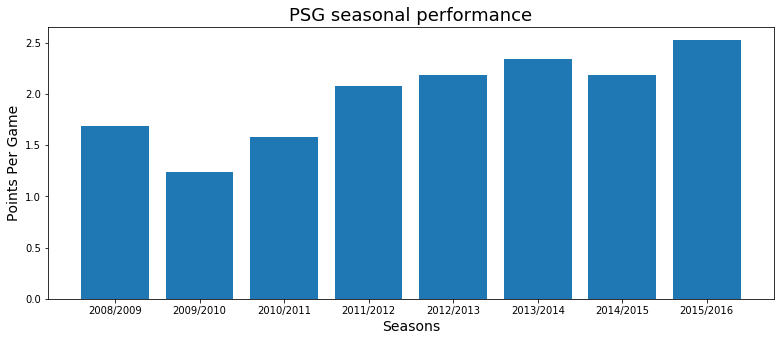

In [22]:
psg=Grouped_by_team.get_group(most_improved_team_id)  #psg is the nickname for Paris Saint-Germain

psg.sort_values(by=['season'], ascending = True,inplace=True)
labels = psg['season']
plt.figure(figsize=(13,5))
plt.bar(labels, psg['points per game'])
plt.title('PSG seasonal performance', fontsize = 18)
plt.ylabel('Points Per Game', fontsize = 14)
plt.xlabel('Seasons', fontsize = 14)


# Question 3: Finding a relationship between the team's performance and the Team Attributes (quantitative attributes only). 

The approach here is to compare the Points Per Game for every team with the quantitative Team Attributes. The team attributes are found in the database and I will be comparing the Points Per game with each attribute, the goal here is to map out the correlation

In [23]:
#in the Database, Sept 10 2015 is for the 2014/2015 season because from the website that gathers this information
# https://sofifa.com/teams/hot    this is the last category in the Fifa 15 game so really they are the stats for
#the 2014/2015 team

# SQL code for team_attributes_2011_2015.csv
#Select team_api_id, date, buildUpPlaySpeed, buildUpPlayDribbling, buildUpPlayPassing, chanceCreationPassing, chanceCreationCrossing, chanceCreationShooting, defencePressure, defenceAggression, defenceTeamWidth
#From Team_Attributes
#Where date like '2013%' or date like '2014%' or date like '2015%' or date like '2012%' or date like '2011%'
#Order by team_api_id, date

#To avoid any misunderstandings and errors, I've made a copy of Team_Points, Team_Points3 to indicate this is for the 3rd question
Team_Points3 = Team_Points.copy()
team_attributes_df= pd.read_csv('team_attributes_2011_2015.csv')
i = 0
team_attributes_df.head()
team_attributes_df = team_attributes_df.rename(columns = {'date': 'season_b'})
while i< len(team_attributes_df):
    if team_attributes_df.loc[i,'season_b'].startswith('2011'):
        team_attributes_df.loc[i,'season_b'] = '2010/2011'
    if team_attributes_df.loc[i,'season_b'].startswith('2012'):
        team_attributes_df.loc[i,'season_b'] = '2011/2012'
    if team_attributes_df.loc[i,'season_b'].startswith('2013'):
        team_attributes_df.loc[i,'season_b'] = '2012/2013'
    if team_attributes_df.loc[i,'season_b'].startswith('2014'):
        team_attributes_df.loc[i,'season_b'] = '2013/2014'
    if team_attributes_df.loc[i,'season_b'].startswith('2015'):
        team_attributes_df.loc[i,'season_b'] = '2014/2015'
    i= i +1
    
print('Complete')

Complete


In [24]:
#Now I will remove rows from Team_Points2 that arent 2010/2011, 2012/2013, 2013/2014, 2014/2015, 2015/2016
Team_Points3 = Team_Points3[(Team_Points3['season'] == '2010/2011') |(Team_Points3['season'] == '2011/2012') |(Team_Points3['season'] == '2012/2013') | (Team_Points3['season'] == '2013/2014') | (Team_Points3['season'] == '2014/2015')] 


In [25]:
Team_Points3.head()

,team_id,season,points per game
807,9773,2010/2011,2.8
1057,9885,2013/2014,2.68421
894,9823,2012/2013,2.67647
895,9823,2013/2014,2.64706
616,8634,2012/2013,2.63158


Now we can merge Team_Points3 with the Team Attributes, we complete the merge on 2 columns team_id and season

In [26]:
Team_Points3['team_id'] = Team_Points3['team_id'].astype(int)

i= 0 

new_df = pd.merge(Team_Points3, team_attributes_df, how = 'inner', left_on = ['team_id','season'], right_on = ['team_api_id','season_b'])

new_df.iloc[:,2] = new_df.iloc[:,2].astype(float)
new_df.iloc[:,5:] = new_df.iloc[:,5:].astype(float)

#converted all the data to float to avoid future bugs comparing different datatypes

new_df.head(3)

,team_id,season,points per game,team_api_id,season_b,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,9773,2010/2011,2.800000,9773,2010/2011,50.0,NaN,50.0,50.0,65.0,65.0,55.0,43.0,65.0
1,9885,2013/2014,2.684211,9885,2013/2014,26.0,47.0,24.0,64.0,53.0,72.0,23.0,67.0,36.0
2,9823,2012/2013,2.676471,9823,2012/2013,56.0,NaN,41.0,40.0,44.0,39.0,52.0,54.0,52.0


Now we itterate through the list of attributes and compare the Team Attributes with the Performance Metric of the Team (Points Per Game). We use Pearson's Correlation Coefficient to discover if any relationships exists. and we can plot a particular characteristic out once a correlation is confirmed

Correlation results and meanings:

Value of 0: No Correlation

-0.29 to +0.29 : Low Degree of Correlation

From 0.3 to 0.49 or -0.3 to -0.49: Medium Degree of Correlation

from 0.5 to 1 or -0.5 to -1: High Degree of Correlation

In [27]:

team_attributes = new_df.columns[5:].tolist()

results=pd.DataFrame(columns =('attribute', 'correlation'))
i=0
for attributes in team_attributes:
    results.at[i,'correlation']= new_df['points per game'].corr(new_df[attributes])
    results.at[i,'attribute'] = attributes
    i=i+1

results

,attribute,correlation
0,buildUpPlaySpeed,0.0139125
1,buildUpPlayDribbling,0.0334862
2,buildUpPlayPassing,-0.191751
3,chanceCreationPassing,0.045872
4,chanceCreationCrossing,0.0677085
5,chanceCreationShooting,0.123493
6,defencePressure,0.304378
7,defenceAggression,0.203082
8,defenceTeamWidth,0.115347


,defencePressure
count,914.000000
mean,45.642232
std,8.954431
min,23.000000
25%,39.000000
50%,46.000000
75%,51.000000
max,72.000000


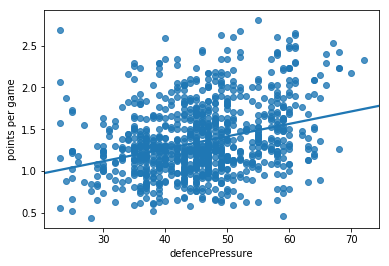

In [28]:
sns.regplot(new_df['defencePressure'], new_df['points per game'], robust=True, ci= None)
pd.DataFrame(new_df['defencePressure'].describe())

In [29]:
pearson_r, p_value = scipy.stats.pearsonr(new_df['defencePressure'], new_df['points per game'])
pearson_r, p_value

(0.3043784940341341, 4.786494783823547e-21)

Results: As we can see, by comparing the whole database, there appears to be a small positive correlation between most attributes and the team's performance (average points per game during the wholw season). The only exception to this was with the BuildUpPassing attribute where the correlation was negative. The strongest correlation was with the 'defencePressure' metric with a pearson r value of 0.304 and a p-value of 0. 

There are 914 data points for every attribute except buildUpPlayPassing where we have 360. 

In the next section we will explore these relationship with respect to teams classified and organized in their respective leagues. The 11 leagues are
- "Belgium Jupiler League"
- "England Premier League"
- "France Ligue 1"
- "Germany 1. Bundesliga"
- "Italy Serie A"
- "Netherlands Eredivisie"
- "Poland Ekstraklasa"
- "Portugal Liga ZON Sagres"
- "Scotland Premier League"
- "Spain LIGA BBVA"
- "Switzerland Super League"

# Section 4: Exploring the Pearson Coefficients for every league.


In [30]:
countries_teams =  df.groupby(['country_id','home_team_api_id'])
#remember, df is the DataFrame from question 1, it represents every match, who played against whom and the results
#the trick here is to group all the teams by country_id and then merge those results with the CSV file that links
#the country_id to the Country

combinations_list = countries_teams.nunique().index.tolist()   #this finds all the combinations for country_id and team_id

Teams_countries=pd.DataFrame(columns=('country_id', 'team_id_b'))

i = 0

for combinations in combinations_list:
    Teams_countries.at[i,'country_id'] = combinations[0]
    Teams_countries.at[i,'team_id_b'] = combinations[1]
    i = i +1


leagues = pd.read_csv('country_leagues.csv', names =('Country', 'League_name', 'id'), header = 0)
leagues.head()


Teams_countries.iloc[:,:] = Teams_countries.iloc[:,:].astype(int)

teams_countries_leagues = pd.merge(Teams_countries, leagues, how = 'inner', left_on = 'country_id', right_on = 'id')
teams_countries_leagues.head()

,country_id,team_id_b,Country,League_name,id
0,1,1773,Belgium,Belgium Jupiler League,1
1,1,4049,Belgium,Belgium Jupiler League,1
2,1,6351,Belgium,Belgium Jupiler League,1
3,1,7947,Belgium,Belgium Jupiler League,1
4,1,8203,Belgium,Belgium Jupiler League,1


In [31]:
teams_countries_leagues.drop(columns = ('id'),inplace= True)

Remember, the DataFrame new_df represents every team_id, for every season along with that team's respective Team Attributes
Now we will merge that information with team_countries_leagues on the team_id index. This means means we will get a new table containing: every team_id, every season, their performance in every season (points per game), their team attributes and a country/league name for them.  

Ignore the NaN values, they are NaN because this Team Attribute was added to later version of Fifa, it will not affect the code

In [32]:
new_df_with_leagues= pd.merge(new_df, teams_countries_leagues, how= 'inner', left_on = 'team_id', right_on = 'team_id_b')
new_df_with_leagues.head(3)

,team_id,season,points per game,team_api_id,season_b,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,country_id,team_id_b,Country,League_name
0,9773,2010/2011,2.8,9773,2010/2011,50.0,NaN,50.0,50.0,65.0,65.0,55.0,43.0,65.0,17642,9773,Portugal,Portugal Liga ZON Sagres
1,9773,2012/2013,2.6,9773,2012/2013,52.0,NaN,53.0,56.0,72.0,68.0,58.0,60.0,57.0,17642,9773,Portugal,Portugal Liga ZON Sagres
2,9773,2011/2012,2.5,9773,2011/2012,52.0,NaN,53.0,56.0,72.0,68.0,61.0,49.0,60.0,17642,9773,Portugal,Portugal Liga ZON Sagres


Now, the plan is to group every country/league independantly by using Pandas' groupby function and then calculating the Pearson's Coefficients, the results will be stored in a new DataFrame in order to see all the results 

In [33]:
#countries = new_df_with_leagues.Country.unique()
#team_attributes

Correlations = pd.DataFrame(columns= ['Country'])
pvals= pd.DataFrame(columns= ['Country'])

grouped= new_df_with_leagues.groupby('Country')

i2=0
for name, country in grouped:
    Correlations.at[i2,'Country'] = name
    pvals.at[i2,'Country'] = name
    for attribute in team_attributes:
        Correlations.at[i2,attribute]= country['points per game'].corr(country[attribute])
        pvals.at[i2,attribute]= scipy.stats.pearsonr(country[attribute], country['points per game'])[1]
    i2=i2+1
    
    

    
Correlations

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


,Country,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,Belgium,0.124187,0.361807,0.023663,0.153821,0.266593,-0.009900,0.381194,0.201187,0.080455
1,England,-0.063919,0.426400,-0.518864,-0.349570,-0.048267,0.162014,0.269318,0.125142,0.273250
2,France,-0.263444,0.229437,-0.195366,0.202277,0.162719,0.037749,0.304763,0.124716,0.074931
3,Germany,0.120863,-0.595693,-0.275883,-0.217527,-0.283669,-0.070245,0.384384,0.135097,-0.055826
4,Italy,-0.117499,0.017895,-0.176271,0.385170,0.163613,0.173760,0.154445,0.288050,-0.239953
5,Netherlands,-0.050675,0.032998,-0.409712,0.000284,0.280294,-0.034032,0.440524,0.158543,0.227668
6,Poland,0.145336,-0.036645,-0.194691,0.048427,-0.078177,0.225968,0.125252,0.137616,0.135585
7,Portugal,0.302817,-0.020156,0.315090,0.293306,0.414271,0.392870,0.553030,0.489070,0.153989
8,Scotland,0.255962,0.304142,-0.001004,0.092365,0.267791,0.406767,0.201661,0.173692,0.456202
9,Spain,-0.218930,-0.002284,-0.255470,-0.043742,-0.260125,0.195579,0.293757,0.194084,0.213708


In [34]:
pvals

,Country,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,Belgium,0.312974,1.0,8.481063e-01,0.210427,0.027981,0.936140,1.340552e-03,0.099941,0.514268
1,England,0.527519,1.0,3.196159e-08,0.000364,0.633447,0.107304,6.736896e-03,0.214763,0.005947
2,France,0.008090,1.0,5.142521e-02,0.043565,0.105763,0.709238,2.049177e-03,0.216341,0.458734
3,Germany,0.256482,1.0,8.489460e-03,0.039444,0.006741,0.510605,1.837354e-04,0.204241,0.601244
4,Italy,0.244319,1.0,7.937772e-02,0.000076,0.103836,0.083822,1.249662e-01,0.003659,0.016190
5,Netherlands,0.635265,1.0,6.070152e-05,0.997878,0.007455,0.750157,1.391907e-05,0.135567,0.030922
6,Poland,0.210324,1.0,9.192788e-02,0.677829,0.502055,0.049674,2.809995e-01,0.235829,0.242883
7,Portugal,0.006328,1.0,4.416211e-03,0.008279,0.000133,0.000312,1.040071e-07,0.000004,0.172633
8,Scotland,0.048383,1.0,9.939247e-01,0.482735,0.038582,0.001259,1.223159e-01,0.184435,0.000249
9,Spain,0.028641,1.0,1.030879e-02,0.665645,0.008957,0.051167,3.013319e-03,0.053006,0.032766


Visualizing the results: Now that we have completed, we are presented with a quick overview for every different league and we now know which attribute pairs have the strongest relationship with the team's performance along with the p-value of the relationship.

For example, I have drawn a regression plot for Portugal's 'chanceCreationCrossing' attribute and the performance. This could help explain England's fast paced football style since the more they 'build up' the more the weaker the performance, more research is needed however.

,chanceCreationCrossing
count,80.000000
mean,55.737500
std,9.025623
min,37.000000
25%,50.000000
50%,53.500000
75%,64.250000
max,76.000000


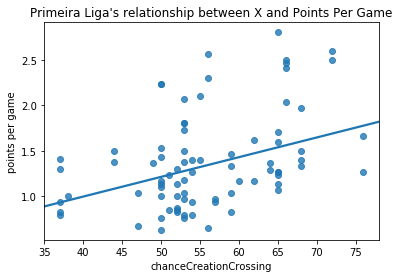

In [35]:
portugal = grouped.get_group('Portugal')


sns.regplot(portugal['chanceCreationCrossing'], portugal['points per game'], robust=True, ci= None).set_title("Primeira Liga's relationship between X and Points Per Game")

pd.DataFrame(portugal['chanceCreationCrossing'].describe())

In [36]:
pearson_r, p_value = scipy.stats.pearsonr(portugal['chanceCreationCrossing'], portugal['points per game'])
pearson_r, p_value

(0.41427057696513014, 0.0001333564166504816)

We can also get some characteristics for this specific group, see below

In [37]:
portugal.describe()

,team_id,points per game,team_api_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,country_id,team_id_b
count,80.000000,80.000000,80.000000,80.000000,34.000000,80.000000,80.0000,80.000000,80.000000,80.000000,80.000000,80.000000,80.0,80.000000
mean,12638.225000,1.385833,12638.225000,51.312500,53.588235,46.000000,54.5250,55.737500,52.300000,43.325000,47.400000,53.337500,17642.0,12638.225000
std,23520.150246,0.528319,23520.150246,10.859976,8.460667,7.685265,6.8676,9.025623,7.629722,9.375129,8.539706,8.354403,0.0,23520.150246
min,2033.000000,0.633333,2033.000000,30.000000,35.000000,30.000000,35.0000,37.000000,35.000000,23.000000,24.000000,35.000000,17642.0,2033.000000
25%,7844.000000,1.000000,7844.000000,41.000000,49.000000,40.000000,52.0000,50.000000,48.000000,37.000000,40.000000,48.000000,17642.0,7844.000000
50%,9772.000000,1.280392,9772.000000,51.500000,53.000000,44.000000,54.0000,53.500000,52.500000,39.000000,48.500000,54.000000,17642.0,9772.000000
75%,10214.000000,1.604412,10214.000000,59.500000,58.750000,52.000000,56.0000,64.250000,55.500000,50.000000,55.000000,60.000000,17642.0,10214.000000
max,158085.000000,2.800000,158085.000000,70.000000,67.000000,66.000000,69.0000,76.000000,69.000000,61.000000,62.000000,68.000000,17642.0,158085.000000


Another type of diagram that I decided to draw was the histogram for one of Italy's attributes below. The X intervals are 5

,chanceCreationPassing
count,100.000000
mean,56.510000
std,11.117822
min,32.000000
25%,50.000000
50%,56.000000
75%,66.000000
max,77.000000


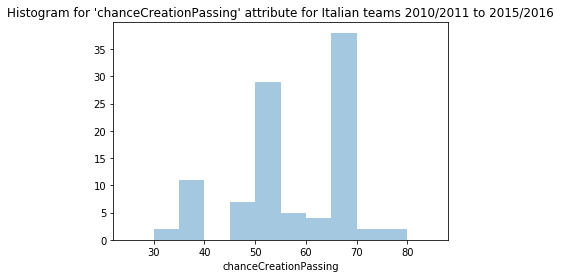

In [38]:
Italy=grouped.get_group('Italy')

sns.distplot(Italy['chanceCreationPassing'], kde=False, bins=[25,30,35,40,45,50,55,60,65,70,75,80,85],hist =True).set_title("Histogram for 'chanceCreationPassing' attribute for Italian teams 2010/2011 to 2015/2016")

pd.DataFrame(Italy['chanceCreationPassing'].describe())

# Project Limitations:

I wanted to briefly discuss the limitations of the analysis. Although the seasonal rankings are clear and accurate after combining 25,000 soccer matches, the limitations are apparent in the second and third section of this analysis.

Firstly, since the database only takes into account matches from 2008/2009 till 2015/2016, any teams that have improved beyond this timeframe have not been included. For the last section, it is imperative to understand that just because there is a strong positive correlation between an attribute and the team's performance, my analysis cannot accurately predict the final result the team would have in the next season. Another limitation to this section is the fact that more team attributes were present but that they were qualitative in nature and I did not know how to properly asses their relationship with regards to the team's seasonal performance. Finally, I am also assuming that the team attributes are accurate and fair but I am not fully aware of the methods and techniques used by the video game series to collect and assess this information.

One more limitation to Question 3 is that by analysing every team in the database, we are comparing average teams in weaker leagues and combining those with Stronger teams in stronger leagues. The limitation here is that we should be analyzing the team's attribute with regards to the attributes' mean in its league. We should be looking at the marginal change in the team attributes amongst teams in the same league, this is why I tried to seperate every league on its own in Section 4. In the future, I hope to update my analysis once I learn how to conduct multivariate statistical analysis.

# Conclusion:
In conclusion I am pretty happy with the short analysis I was able to make. From a large database, I was able to categorize the data with regards to performance, find the team that improved the most and ultimately, determine if a correlation existed between Team Attributes and the team's performance.

In the coming months, I hope to learn more about conducting statistical analysis and one day I hope I will be able to answer more questions and create personal and customizable prediction models for this type of data. At first I wanted to create a model that weighted the different team metrics to create an overall function but this was a little ambitious and out of the scope of the course material. That being said, programming with python and the Pandas module was a very fun and personally rewarding experience. 


